This demo presents the usage of NiftyNet's image sampler implemented at `niftynet.contrib.dataset_sampler.*`

What's a `sampler`?

The sampler takes an image reader as input, produces image windows sampled from each image.

Why `sampler`?

In many cases in medical imaging applications, deep neural networks operate on image windows instead of the entire images/datasets, partly due to the GPU memory limitation and training efficiencies. The sampler provides ready-to-use interfaces to generate image windows, works well with `tf.data.Dataset`.

## Before the demo...

First make sure the source code is available, and import the module.

For NiftyNet installation, please checkout:

http://niftynet.readthedocs.io/en/dev/installation.html

For demonstration purpose we download some demo data to `~/niftynet/data/`

For visualisation we install `matplotlib`.

In [158]:
import sys
niftynet_path = '/Users/foo/Documents/Niftynet/'
sys.path.insert(0, niftynet_path)

from niftynet.utilities.download import download
download('mr_ct_regression_model_zoo_data')

!{sys.executable} -m pip install matplotlib

Accessing: https://cmiclab.cs.ucl.ac.uk/CMIC/NiftyNetExampleServer
mr_ct_regression_model_zoo_data: OK. 
Already downloaded. Use the -r option to download again.


# Image as 'window'

The simplest use case is treating each image as an image window. This is implemented by default using `ImageWindowDataset` class from `niftynet.contrib.dataset_sampler`. This class also acts as a base class, which can be extended to generate smaller windows using different sampling strategies.

In [159]:
from niftynet.io.image_reader import ImageReader
from niftynet.engine.image_window_dataset import ImageWindowDataset

# creating an image reader.
data_param = \
    {'CT': {'path_to_search': '~/niftynet/data/mr_ct_regression/CT_zero_mean',
            'filename_contains': 'nii'}}
reader = ImageReader().initialise(data_param)

# creating a window sampler dataset from the reader
sampler = ImageWindowDataset(reader)

INFO:niftynet: 

Number of subjects 15, input section names: ['subject_id', 'CT']
-- using all subjects (without data partitioning).

INFO:niftynet: Image reader: loading 15 subjects from sections ('CT',) as input [CT]


The sampler can be used as a numpy function, or a tensorflow operation.
### Use the sampler as a numpy function
Directly call the instance (this is actually invoking `sampler.layer_op`):

dict_keys(['CT', 'CT_location']) [[  0   0   0   0 288 288   1]] (1, 288, 288, 1, 1, 1)


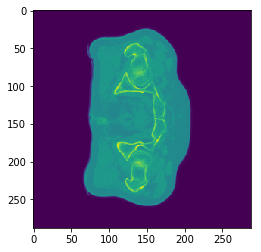

In [160]:
windows = sampler()
print(windows.keys(), windows['CT_location'], windows['CT'].shape)
    
import matplotlib.pyplot as plt
plt.imshow(windows['CT'][0,:,:,0,0,0])
plt.show()

### Use the sampler as a tensorflow op
First add a iterator node, this is wrapped as `pop_batch_op()`,
then run the op.

In [161]:
import tensorflow as tf
# adding the tensorflow tensors
next_window = sampler.pop_batch_op()

# run the tensors
with tf.Session() as sess:
    sampler.run_threads(sess) #initialise the iterator
    windows = sess.run(next_window)
    print(windows.keys(), windows['CT_location'], windows['CT'].shape)


dict_keys(['CT', 'CT_location']) [[  5   0   0   0 288 288   1]] (1, 288, 288, 1, 1)


- The location array `['MR_location']` represents the spatial coordinates of the window: 
  
  `[subject_id, x_start, y_start, z_start, x_end, y_end, z_end]`


- As a numpy function, the output shape is `(1, x, y, z, 1, 1)` which represents batch, width, height, depth, time points, channels. As a tensorflow op, the output shape is `(batch, x,[ y,][ z,] channels)`, which means the time dimension (not currently supported) and the spatial axes will be "squeezed" if the length along them is one. This simplifies the network definitions based on 2D or 3D outputs of the sampler.


# Uniform sampler
Generating image windows randomly from images.

This is implemented by overriding the `layer_op` of `ImageWindowDataset`.

The following code creates a uniform sampler and draws an image window.

Two sections `MR` and `CT` are given as the input data parameter,
the reader loads these sections by matching the filenames, and
outputs the sampling windows (from the same spatial coordinates for all input images) as a dictionary.

- When the spatial window sizes are different in `MR` and `CT`, concentric windows will be sampled.

- When the spatial window size is (0, 0, 0), size of the first image from the reader will be used as the window size.

- `windows_per_image` parameter specifies the number of image windows from each image returned by the reader.

INFO:niftynet: 

Number of subjects 15, input section names: ['subject_id', 'MR', 'CT']
-- using all subjects (without data partitioning).

INFO:niftynet: Image reader: loading 15 subjects from sections ('MR',) as input [MR]
INFO:niftynet: Image reader: loading 15 subjects from sections ('CT',) as input [CT]
INFO:niftynet: initialised uniform sampler {'MR': (1, 80, 80, 1, 1, 1), 'MR_location': (1, 7), 'CT': (1, 80, 80, 1, 1, 1), 'CT_location': (1, 7)} 
[[  2  38  66   0 118 146   1]
 [  1  90 164   0 170 244   1]] (2, 80, 80, 1)
[[  2  38  66   0 118 146   1]
 [  1  90 164   0 170 244   1]] (2, 80, 80, 1)


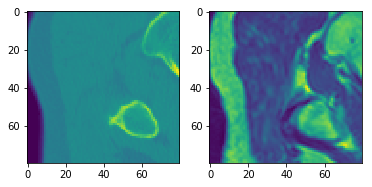

In [169]:
from niftynet.io.image_reader import ImageReader
from niftynet.engine.sampler_uniform_v2 import UniformSampler

# creating an image reader.
# creating an image reader.
data_param = \
    {'MR': {'path_to_search': '~/niftynet/data/mr_ct_regression/CT_zero_mean',
            'filename_contains': 'nii',
            'spatial_window_size': (80, 80, 1)},
     'CT': {'path_to_search': '~/niftynet/data/mr_ct_regression/T2_corrected',
            'filename_contains': 'nii',
            'spatial_window_size': (80, 80, 1)},
    }
window_sizes = {'MR': (80, 80, 1), 'CT': (80, 80, 1)}
reader = ImageReader().initialise(data_param)

# uniform sampler returns windows of 32^3-voxels
uniform_sampler = UniformSampler(
    reader, window_sizes, batch_size=2, windows_per_image=5)


import tensorflow as tf
# adding the tensorflow tensors
next_window = uniform_sampler.pop_batch_op()

# run the tensors
with tf.Session() as sess:
    uniform_sampler.run_threads(sess) #initialise the iterator
    windows = sess.run(next_window)
    print(windows['MR_location'], windows['MR'].shape)
    print(windows['CT_location'], windows['CT'].shape)


import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1,2,1)
plt.imshow(windows['MR'][0,:,:,0])
plt.subplot(1,2,2)
plt.imshow(windows['CT'][0,:,:,0])
plt.show()

# Grid sampler
Generatoring image windows from images with a sliding window.

This is implemented by overriding the `layer_op` of `ImageWindowDataset`.

The `window_border` parameter controls the amount of overlap in between sampling windows.
When the grid sampler is used for fully convolutional inference, the overlapping regions of the windows are cropped, so that the windows can be aggregated as an image at the resolution of the input.  

See also: http://niftynet.readthedocs.io/en/dev/config_spec.html#border

In [163]:
from niftynet.io.image_reader import ImageReader
from niftynet.engine.sampler_grid_v2 import GridSampler

# creating an image reader.
data_param = \
    {'CT': {'path_to_search': '~/niftynet/data/mr_ct_regression/CT_zero_mean',
            'filename_contains': 'nii'}}
reader = ImageReader().initialise(data_param)

# uniform sampler returns windows of 32^3-voxels
uniform_sampler = GridSampler(reader, 
                              window_sizes=(42, 42, 1), 
                              window_border=(8,8,1), batch_size=1)


import tensorflow as tf
# adding the tensorflow tensors
next_window = uniform_sampler.pop_batch_op()

# run the tensors
with tf.Session() as sess:
    uniform_sampler.run_threads(sess) #initialise the iterator
    subject_id = 0
    coords = []
    while True:
        windows = sess.run(next_window)
        if not subject_id == windows['CT_location'][0,0]:
            break;
        #print(windows.keys(), windows['MR_location'], windows['MR'].shape)
        coords.append(windows['CT_location'])

INFO:niftynet: 

Number of subjects 15, input section names: ['subject_id', 'CT']
-- using all subjects (without data partitioning).

INFO:niftynet: Image reader: loading 15 subjects from sections ('CT',) as input [CT]
INFO:niftynet: initialised window instance
INFO:niftynet: initialised grid sampler {'CT': (1, 42, 42, 1, 1, 1), 'CT_location': (1, 7)}
INFO:niftynet: grid sampling image sizes: {'CT': (288, 288, 1, 1, 1)}
INFO:niftynet: grid sampling window sizes: {'CT': (42, 42, 1, 1, 1)}
INFO:niftynet: yielding 121 locations from image
INFO:niftynet: grid sampling image sizes: {'CT': (288, 288, 1, 1, 1)}
INFO:niftynet: grid sampling window sizes: {'CT': (42, 42, 1, 1, 1)}
INFO:niftynet: yielding 121 locations from image


Visualisation of the window coordinates (change `window_sizes` and `window_border` to see different window allocations):

(288, 288, 1, 1, 1)


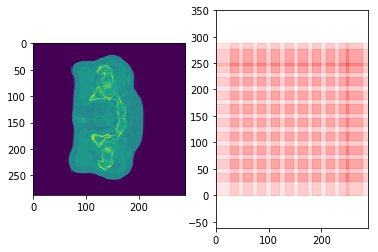

In [164]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

f, (ax1, ax) = plt.subplots(1,2)

# show image
_, img, _ = reader(idx=0)
print(img['CT'].shape)
plt.subplot(1,2,1)
plt.imshow(img['CT'][:,:,0,0,0])

# show sampled windows
all_patch = []
for win in np.concatenate(coords, axis=0):
    patch = patches.Rectangle(
        (win[1], win[2]),
        win[4]-win[1], win[5]-win[2], linewidth=1)
    all_patch.append(patch)
all_pc = PatchCollection(
    all_patch, alpha=0.1, edgecolor='r', facecolor='r')
ax.add_collection(all_pc)
ax.set_xlim([0, np.max(coords, axis=0)[0,4]])
ax.set_ylim([0, np.max(coords, axis=0)[0,5]])
ax.set_aspect('equal', 'datalim')
plt.show()

# Weighted sampler
Generatoring image windows from images with a sampling prior of the foreground.

This sampler uses a cumulative histogram for fast sampling, works with both continous and discrete maps.
It is implemented by overriding the `layer_op` of `ImageWindowDataset`.

Weight map can be specified by an input specification with `sampler` as the key.

The following example uses a binary mask as the weight map.

In [165]:
from niftynet.io.image_reader import ImageReader
from niftynet.engine.sampler_weighted_v2 import WeightedSampler

# creating an image reader.
data_param = \
    {'CT':      {'path_to_search': '~/niftynet/data/mr_ct_regression/CT_zero_mean',
                 'filename_contains': 'PAR.nii.gz'},
     'sampler': {'path_to_search': '~/niftynet/data/mr_ct_regression/T2_mask',
                 'filename_contains': 'nii'}}
reader = ImageReader().initialise(data_param)

weighted_sampler = WeightedSampler(
    reader, window_sizes=(12, 12, 1), batch_size=1, windows_per_image=100)

import tensorflow as tf
# adding the tensorflow tensors
next_window = weighted_sampler.pop_batch_op()

# run the tensors
with tf.Session() as sess:
    weighted_sampler.run_threads(sess) #initialise the iterator
    coords = []
    for _ in range(200):
        windows = sess.run(next_window)
        #print(windows.keys(), windows['CT_location'], windows['CT'].shape)
        coords.append(windows['CT_location'])

INFO:niftynet: 

Number of subjects 15, input section names: ['subject_id', 'CT', 'sampler']
-- using all subjects (without data partitioning).

INFO:niftynet: Image reader: loading 1 subjects from sections ('CT',) as input [CT]
INFO:niftynet: Image reader: loading 1 subjects from sections ('sampler',) as input [sampler]
INFO:niftynet: initialised uniform sampler {'CT': (100, 12, 12, 1, 1, 1), 'CT_location': (100, 7), 'sampler': (100, 12, 12, 1, 1, 1), 'sampler_location': (100, 7)} 
INFO:niftynet: Initialised weighted sampler window instance


(288, 288, 1, 1, 1)


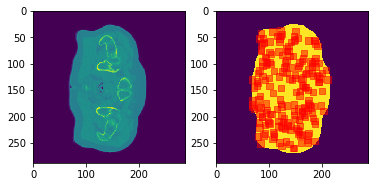

In [166]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

f, (ax1, ax) = plt.subplots(1,2)

# show image
_, img, _ = reader(idx=0)
print(img['CT'].shape)
plt.subplot(1,2,1)
plt.imshow(img['CT'][:,:,0,0,0])
#plt.subplot(1,2,2)
ax.imshow(img['sampler'][:,:,0,0,0])

# show sampled windows
all_patch = []
for win in np.concatenate(coords, axis=0):
    patch = patches.Rectangle(
        (win[2], win[1]),
        win[5]-win[2], win[4]-win[1], linewidth=1)
    all_patch.append(patch)
all_pc = PatchCollection(
    all_patch, alpha=0.5, edgecolor='r', facecolor='r')
ax.add_collection(all_pc)
plt.show()

# Balanced sampler
Generatoring image windows from images with a sampling prior of the foreground.

This sampler generates image windows from a discrete label map as if every label
had the same probability of occurrence.
It is implemented by overriding the `layer_op` of `ImageWindowDataset`.

Weight map can be specified by an input specification with `sampler` as the key.
The following example uses a foreground mask as the weight map.

In [167]:
from niftynet.io.image_reader import ImageReader
from niftynet.engine.sampler_balanced_v2 import BalancedSampler

# creating an image reader.
data_param = \
    {'CT':      {'path_to_search': '~/niftynet/data/mr_ct_regression/CT_zero_mean',
                 'filename_contains': 'PAR.nii.gz'},
     'sampler': {'path_to_search': '~/niftynet/data/mr_ct_regression/T2_mask',
                 'filename_contains': 'nii'}}
reader = ImageReader().initialise(data_param)

balanced_sampler = BalancedSampler(
    reader, window_sizes=(12, 12, 1), windows_per_image=100)

import tensorflow as tf
# adding the tensorflow tensors
next_window = balanced_sampler.pop_batch_op()

# run the tensors
with tf.Session() as sess:
    balanced_sampler.run_threads(sess) #initialise the iterator
    coords = []
    for _ in range(200):
        windows = sess.run(next_window)
        #print(windows.keys(), windows['CT_location'], windows['CT'].shape)
        coords.append(windows['CT_location'])

INFO:niftynet: 

Number of subjects 15, input section names: ['subject_id', 'CT', 'sampler']
-- using all subjects (without data partitioning).

INFO:niftynet: Image reader: loading 1 subjects from sections ('CT',) as input [CT]
INFO:niftynet: Image reader: loading 1 subjects from sections ('sampler',) as input [sampler]
INFO:niftynet: initialised uniform sampler {'CT': (100, 12, 12, 1, 1, 1), 'CT_location': (100, 7), 'sampler': (100, 12, 12, 1, 1, 1), 'sampler_location': (100, 7)} 
INFO:niftynet: Initialised balanced sampler window instance


Visualisation of the window coordinates (change `data_param` see different window allocations):

(288, 288, 1, 1, 1)


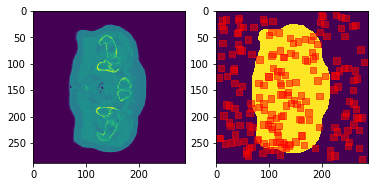

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

f, (ax1, ax) = plt.subplots(1,2)

# show image
_, img, _ = reader(idx=0)
print(img['CT'].shape)
plt.subplot(1,2,1)
plt.imshow(img['CT'][:,:,0,0,0])
#plt.subplot(1,2,2)
ax.imshow(img['sampler'][:,:,0,0,0])

# show sampled windows
all_patch = []
for win in np.concatenate(coords, axis=0):
    patch = patches.Rectangle(
        (win[2], win[1]),
        win[5]-win[2], win[4]-win[1], linewidth=1)
    all_patch.append(patch)
all_pc = PatchCollection(
    all_patch, alpha=0.5, edgecolor='r', facecolor='r')
ax.add_collection(all_pc)
plt.show()